<a href="https://colab.research.google.com/github/AdsonRamos/if697-2020.2/blob/main/Projeto_IF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando dependências

Se estiver executando este notebook no Google Colab, descomente a célula abaixo antes de executar o notebook.

In [164]:
# pip install geopandas

# Importando dependências

In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import geopandas

import math

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Carregando dados

In [166]:
customers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_customers_dataset.csv", encoding="ISO-8859-1")
geolocation = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_geolocation_dataset.csv", encoding="ISO-8859-1")
order_items = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_order_items_dataset.csv", encoding="ISO-8859-1")
order_payments = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_order_payments_dataset.csv", encoding="ISO-8859-1")
order_reviews = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_order_reviews_dataset.csv", encoding="ISO-8859-1")
orders = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_orders_dataset.csv", encoding="ISO-8859-1")
products = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_products_dataset.csv", encoding="ISO-8859-1")
sellers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_sellers_dataset.csv", encoding="ISO-8859-1")
states_maps = geopandas.read_file("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/br_states_shapefiles.zip")

# Descrição inicial dos datasets

In [167]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [168]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [169]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [170]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [171]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [172]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [173]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [174]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


Podemos ver que o dataset de geolocalizações é o maior de todos, com mais de 1 milhão de entradas. No outro extremo, temos o de vendedores, com cerca de 3 mil.

A maioria das colunas não apresenta valores nulos, mas o dataset de resenhas tem as colunas `review_comment_title` e `review_comment_message` com muitos valores nulos. Também chama a atenção os datasets de produtos e pedidos, onde algumas colunas possuem poucos valores nulos.

# Estudo sobre o dataset de clientes

In [175]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [176]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


<AxesSubplot:xlabel='Estados', ylabel='Clientes'>

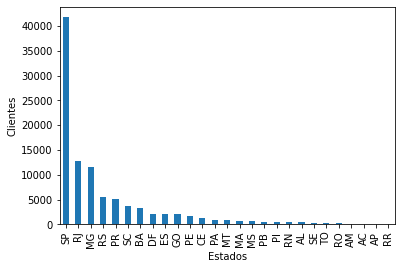

In [177]:
#Estados mais frequentes nos clientes
customers['customer_state'].value_counts().plot(kind='bar', ylabel='Clientes', xlabel='Estados')

## Agrupamento por regiões

In [178]:
sudeste = ['MG', 'RJ', 'ES', 'SP']
nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PI', 'PE', 'RN', 'SE']
sul = ['PR', 'RS', 'SC']
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'MS', 'GO', 'DF']

[Text(0.5, 1.0, 'Centro-Oeste')]

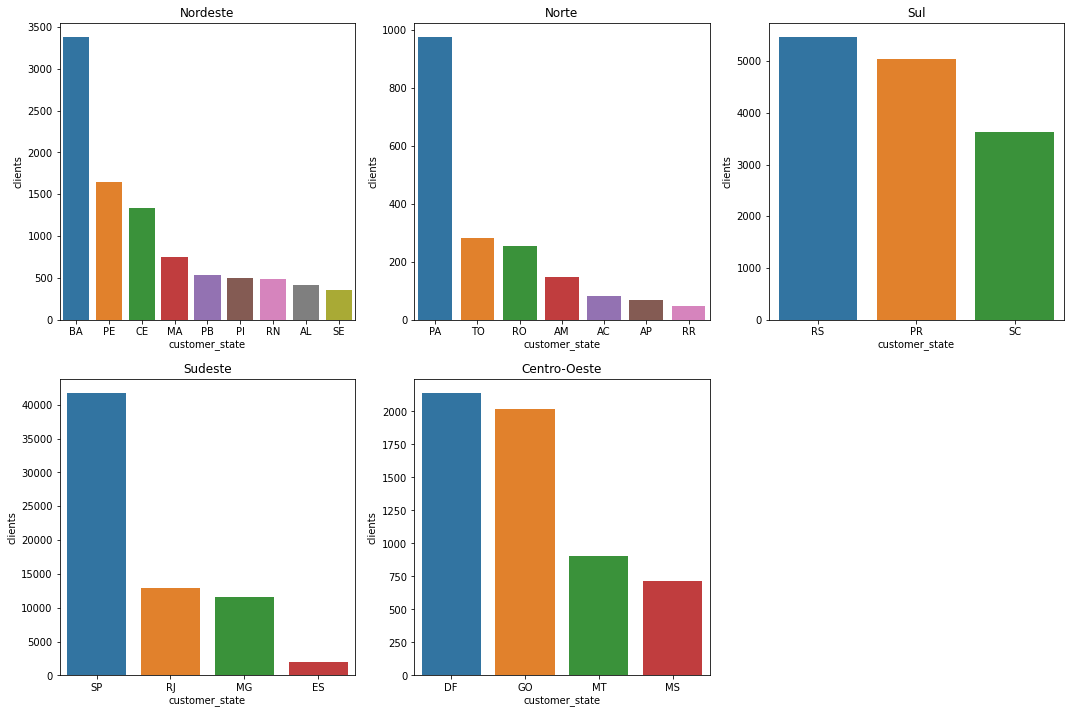

In [179]:
#Clientes distribuídos por regiões do país

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))
fig.delaxes(axes[1,2])

northeast_client_counts = customers[customers.customer_state.isin(nordeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
northeast_client_counts["customer_state"] = northeast_client_counts["customer_state"].astype('category')

north_client_counts = customers[customers.customer_state.isin(norte)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
north_client_counts["customer_state"] = north_client_counts["customer_state"].astype('category')

south_client_counts = customers[customers.customer_state.isin(sul)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
south_client_counts["customer_state"] = south_client_counts["customer_state"].astype('category')

southeast_client_counts = customers[customers.customer_state.isin(sudeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
southeast_client_counts["customer_state"] = southeast_client_counts["customer_state"].astype('category')

midwest_client_counts = customers[customers.customer_state.isin(centro_oeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
midwest_client_counts["customer_state"] = midwest_client_counts["customer_state"].astype('category')

sns.barplot(x='customer_state', y='clients', order=northeast_client_counts['customer_state'], data=northeast_client_counts, ax=axes[0][0]).set(title="Nordeste")
sns.barplot(x='customer_state', y='clients', order=north_client_counts['customer_state'], data=north_client_counts, ax=axes[0][1]).set(title="Norte")
sns.barplot(x='customer_state', y='clients', order=south_client_counts['customer_state'], data=south_client_counts, ax=axes[0][2]).set(title="Sul")
sns.barplot(x='customer_state', y='clients', order=southeast_client_counts['customer_state'], data=southeast_client_counts, ax=axes[1][0]).set(title="Sudeste")
sns.barplot(x='customer_state', y='clients', order=midwest_client_counts['customer_state'], data=midwest_client_counts, ax=axes[1][1]).set(title="Centro-Oeste")

# Estudo sobre as localizações

In [180]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [181]:
geolocation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


In [182]:
world_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [183]:
points = geopandas.GeoDataFrame(geolocation, geometry=geopandas.points_from_xy(geolocation['geolocation_lng'], geolocation['geolocation_lat']))
points.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geometry
0,1037,-23.545621,-46.639292,sao paulo,SP,POINT (-46.63929 -23.54562)
1,1046,-23.546081,-46.644820,sao paulo,SP,POINT (-46.64482 -23.54608)
2,1046,-23.546129,-46.642951,sao paulo,SP,POINT (-46.64295 -23.54613)
3,1041,-23.544392,-46.639499,sao paulo,SP,POINT (-46.63950 -23.54439)
4,1035,-23.541578,-46.641607,sao paulo,SP,POINT (-46.64161 -23.54158)


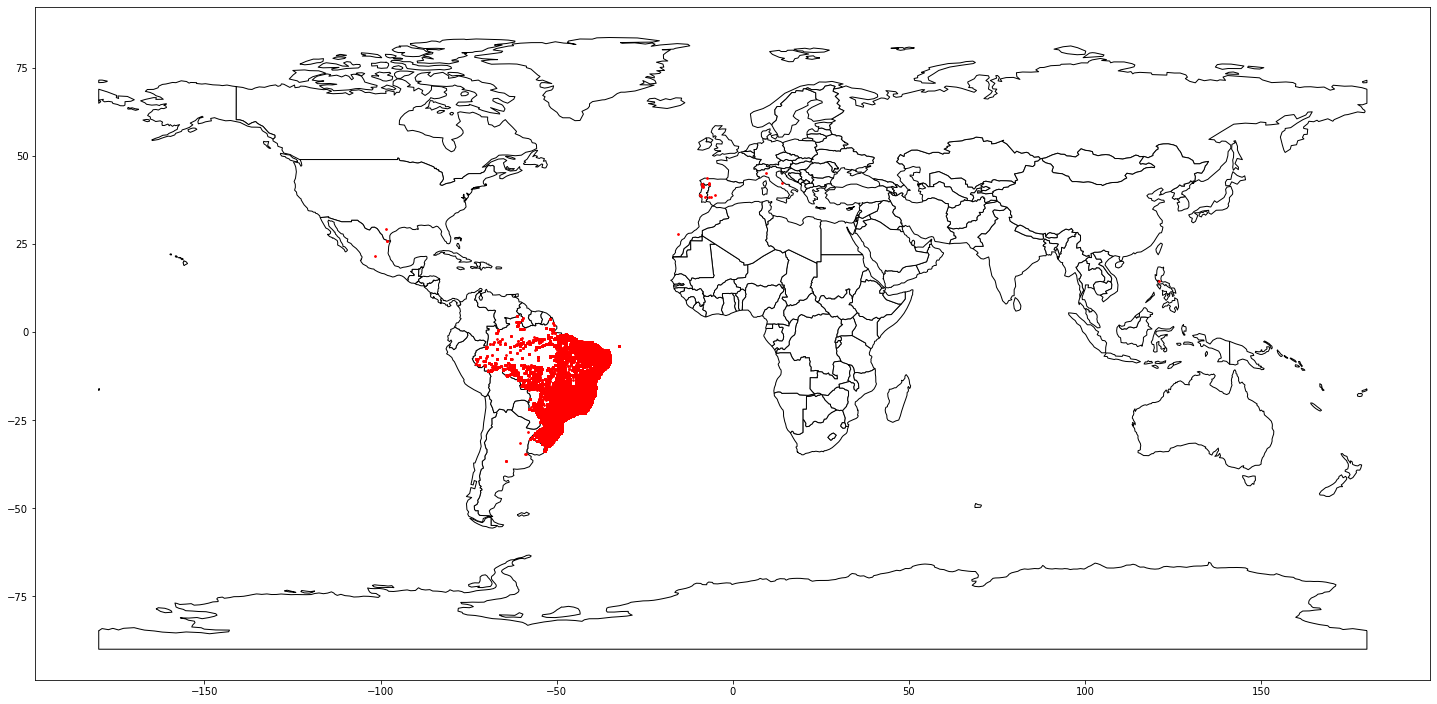

In [184]:
# Localização dos pedidos em relação ao mundo
ax = world_map.plot(color='white', edgecolor='black', figsize=(25,20))
points.plot(ax=ax, color='red', markersize=3)
plt.show()

In [185]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=4)
predictions = clf.fit_predict(geolocation[['geolocation_lng', 'geolocation_lat']])
predictions[predictions == -1] = 0
predictions = predictions.astype('bool')

In [186]:
outlier_points = points[predictions]
inlier_points = points[~predictions]

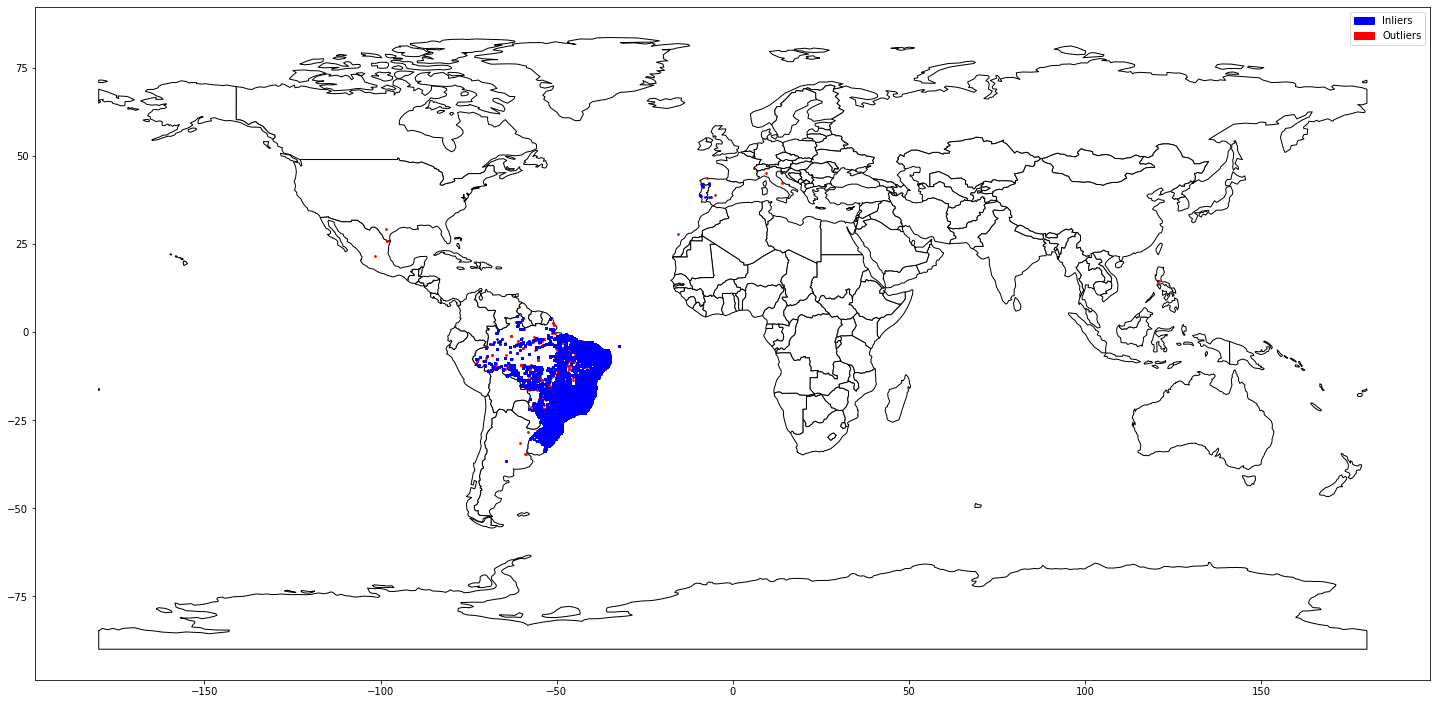

In [187]:
ax = world_map.plot(color='white', edgecolor='black', figsize=(25,20))
inlier_points.plot(ax=ax, color='red', markersize=3)
outlier_points.plot(ax=ax, color='blue', markersize=3)
blue_patch = mpatches.Patch(color='blue', label='Inliers')
red_patch = mpatches.Patch(color='red', label='Outliers')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

In [188]:
# Localização dos pedidos no Brasil
states_maps

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,33,BRA,Brazil,1,Acre,BR.AC,0,None,Estado,State,None,None,"POLYGON ((-73.33251 -7.32488, -73.27482 -7.350..."
1,33,BRA,Brazil,2,Alagoas,BR.AL,0,None,Estado,State,None,None,"MULTIPOLYGON (((-35.90153 -9.86180, -35.90153 ..."
2,33,BRA,Brazil,3,Amapá,BR.AP,0,None,Estado,State,None,None,"MULTIPOLYGON (((-50.02403 0.85986, -50.02403 0..."
3,33,BRA,Brazil,4,Amazonas,BR.AM,0,None,Estado,State,None,Amazone,"POLYGON ((-67.32623 2.02968, -67.30118 1.92997..."
4,33,BRA,Brazil,5,Bahia,BR.BA,0,None,Estado,State,None,Ba¡a,"MULTIPOLYGON (((-38.69708 -17.97903, -38.69708..."
5,33,BRA,Brazil,6,Ceará,BR.CE,0,None,Estado,State,None,None,"MULTIPOLYGON (((-38.47542 -3.70097, -38.47542 ..."
6,33,BRA,Brazil,7,Distrito Federal,BR.DF,0,None,Distrito Federal,Federal District,None,None,"POLYGON ((-48.03603 -15.50022, -47.77200 -15.5..."
7,33,BRA,Brazil,8,Espírito Santo,BR.ES,0,None,Estado,State,None,Espiritu Santo,"MULTIPOLYGON (((-40.88403 -21.16125, -40.88403..."
8,33,BRA,Brazil,9,Goiás,BR.GO,0,None,Estado,State,None,Goiáz|Goyáz,"POLYGON ((-50.15817 -12.41238, -50.15942 -12.4..."
9,33,BRA,Brazil,10,Maranhão,BR.MA,0,None,Estado,State,None,São Luíz de Maranhão,"MULTIPOLYGON (((-42.12375 -2.80069, -42.12375 ..."


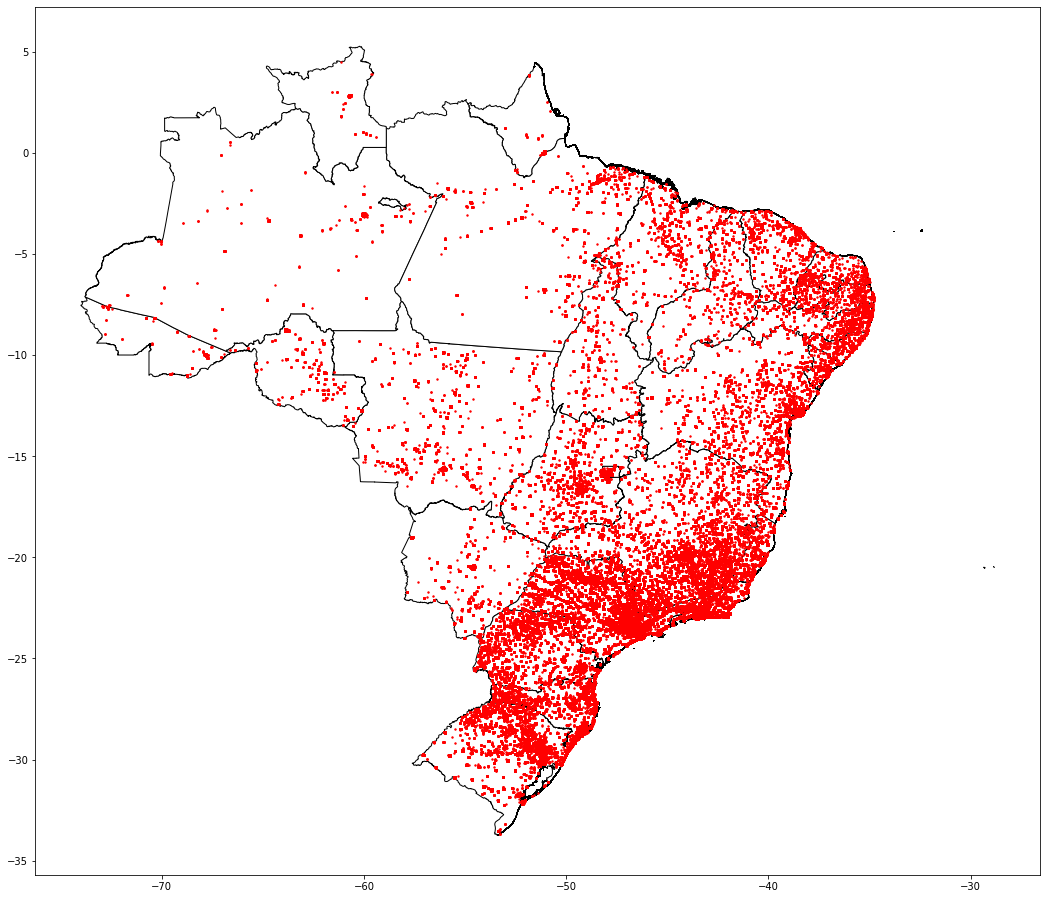

In [189]:
brazil_map = world_map[world_map['name'] == 'Brazil']
points_in_brazil = points.within(brazil_map.iloc[0]['geometry'])
ax = states_maps.plot(color='white', edgecolor='black', figsize=(18,18))
points[points_in_brazil].plot(ax=ax, color='red', markersize=2)
plt.show()

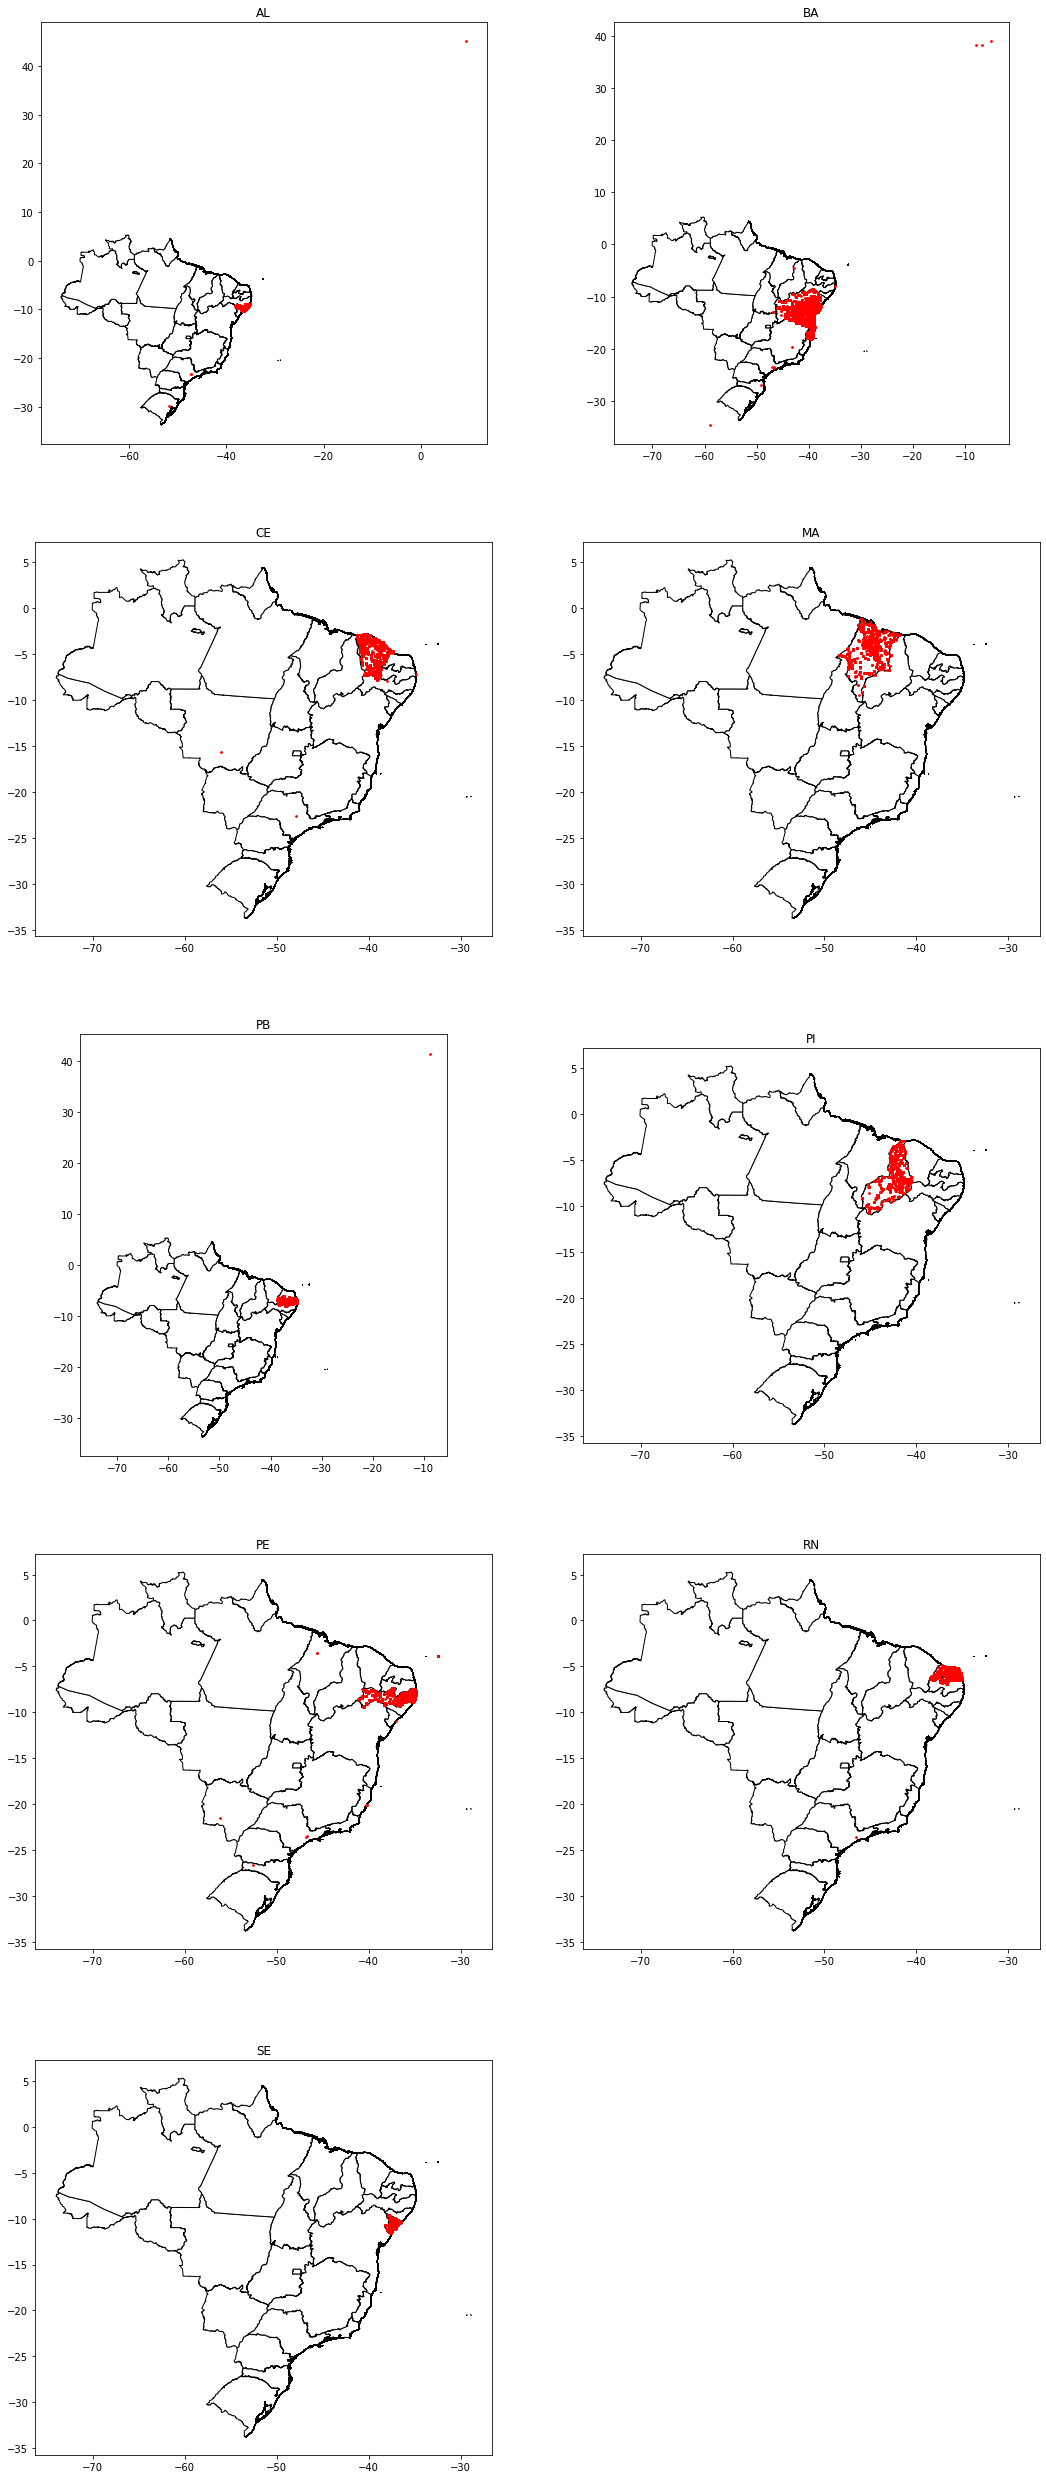

In [190]:
# Localização dos pedidos no nordeste
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(18, 45))
fig.delaxes(axes[4,1])
even_nordeste = nordeste + ['N/A']
state_grid = np.reshape(even_nordeste, (5, 2))
for state_row, ax_row in zip(state_grid, axes):
    for state, base_ax in zip(state_row, ax_row):
        if state == "N/A":
            continue
        base_ax.set_title(state)
        points_in_state = points[points['geolocation_state'] == state]
        states_ax = states_maps.plot(ax=base_ax, color='white', edgecolor='black')
        points_in_state.plot(ax=states_ax, color='red', markersize=3)

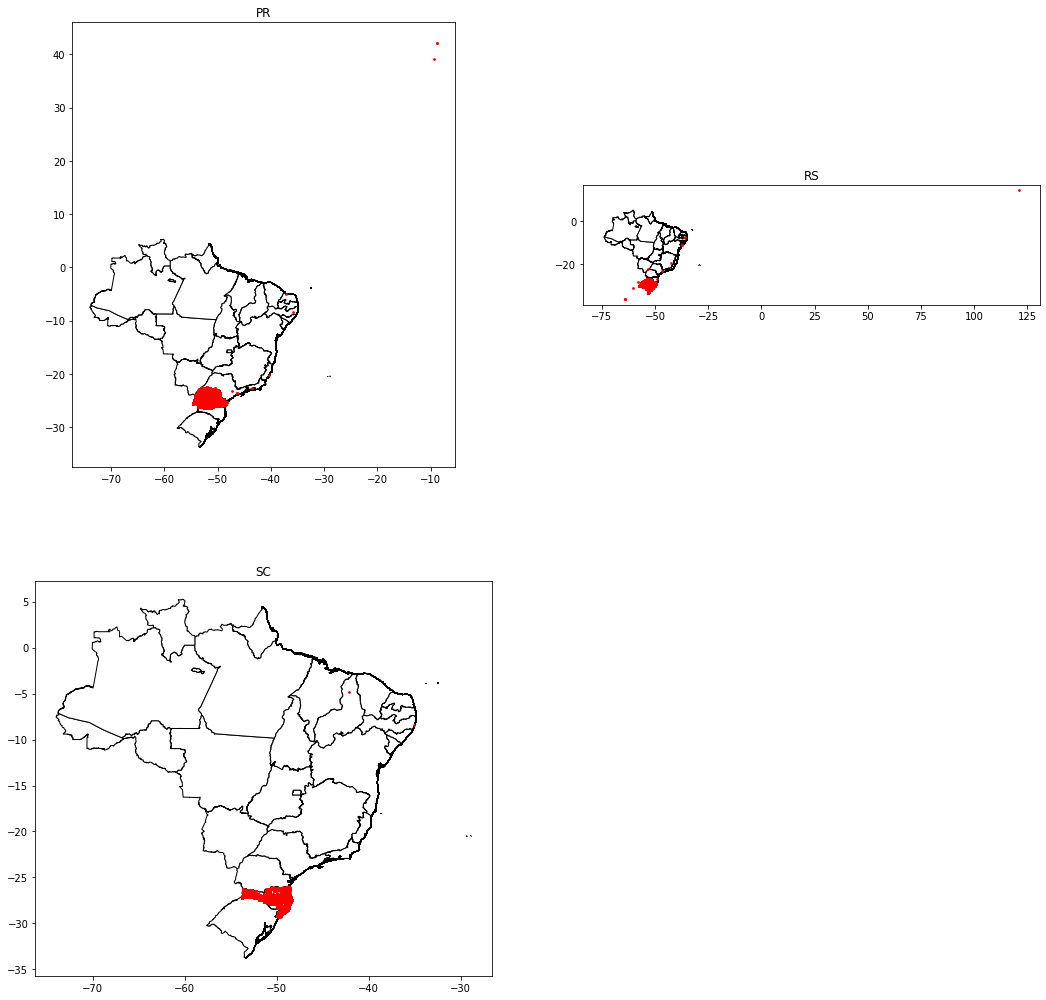

In [191]:
# Localização dos pedidos no sul
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 18))
fig.delaxes(axes[1,1])
even_sul = sul + ['N/A']
state_grid = np.reshape(even_sul, (2, 2))
for state_row, ax_row in zip(state_grid, axes):
    for state, base_ax in zip(state_row, ax_row):
        if state == "N/A":
            continue
        base_ax.set_title(state)
        points_in_state = points[points['geolocation_state'] == state]
        states_ax = states_maps.plot(ax=base_ax, color='white', edgecolor='black')
        points_in_state.plot(ax=states_ax, color='red', markersize=3)

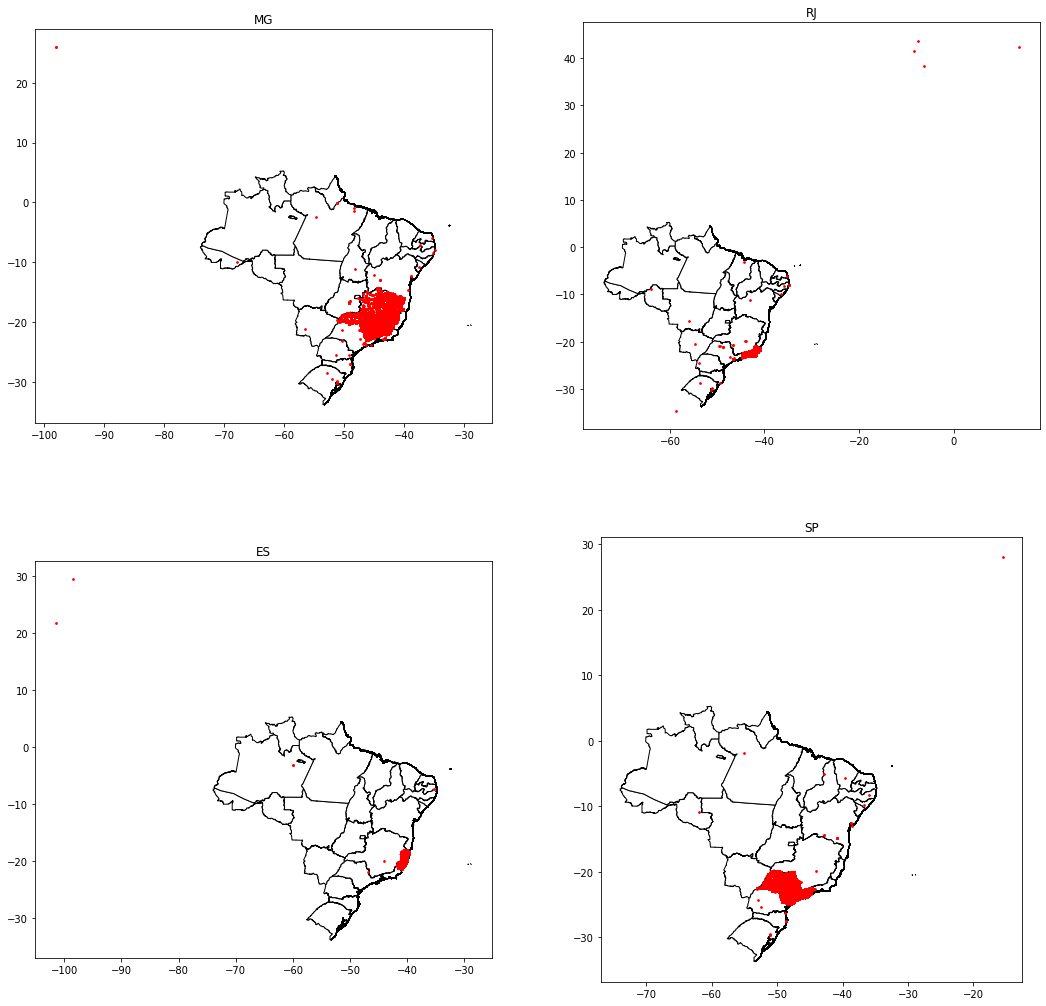

In [192]:
# Localização dos pedidos no sudeste
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 18))
state_grid = np.reshape(sudeste, (2, 2))
for state_row, ax_row in zip(state_grid, axes):
    for state, base_ax in zip(state_row, ax_row):
        base_ax.set_title(state)
        points_in_state = points[points['geolocation_state'] == state]
        states_ax = states_maps.plot(ax=base_ax, color='white', edgecolor='black')
        points_in_state.plot(ax=states_ax, color='red', markersize=3)

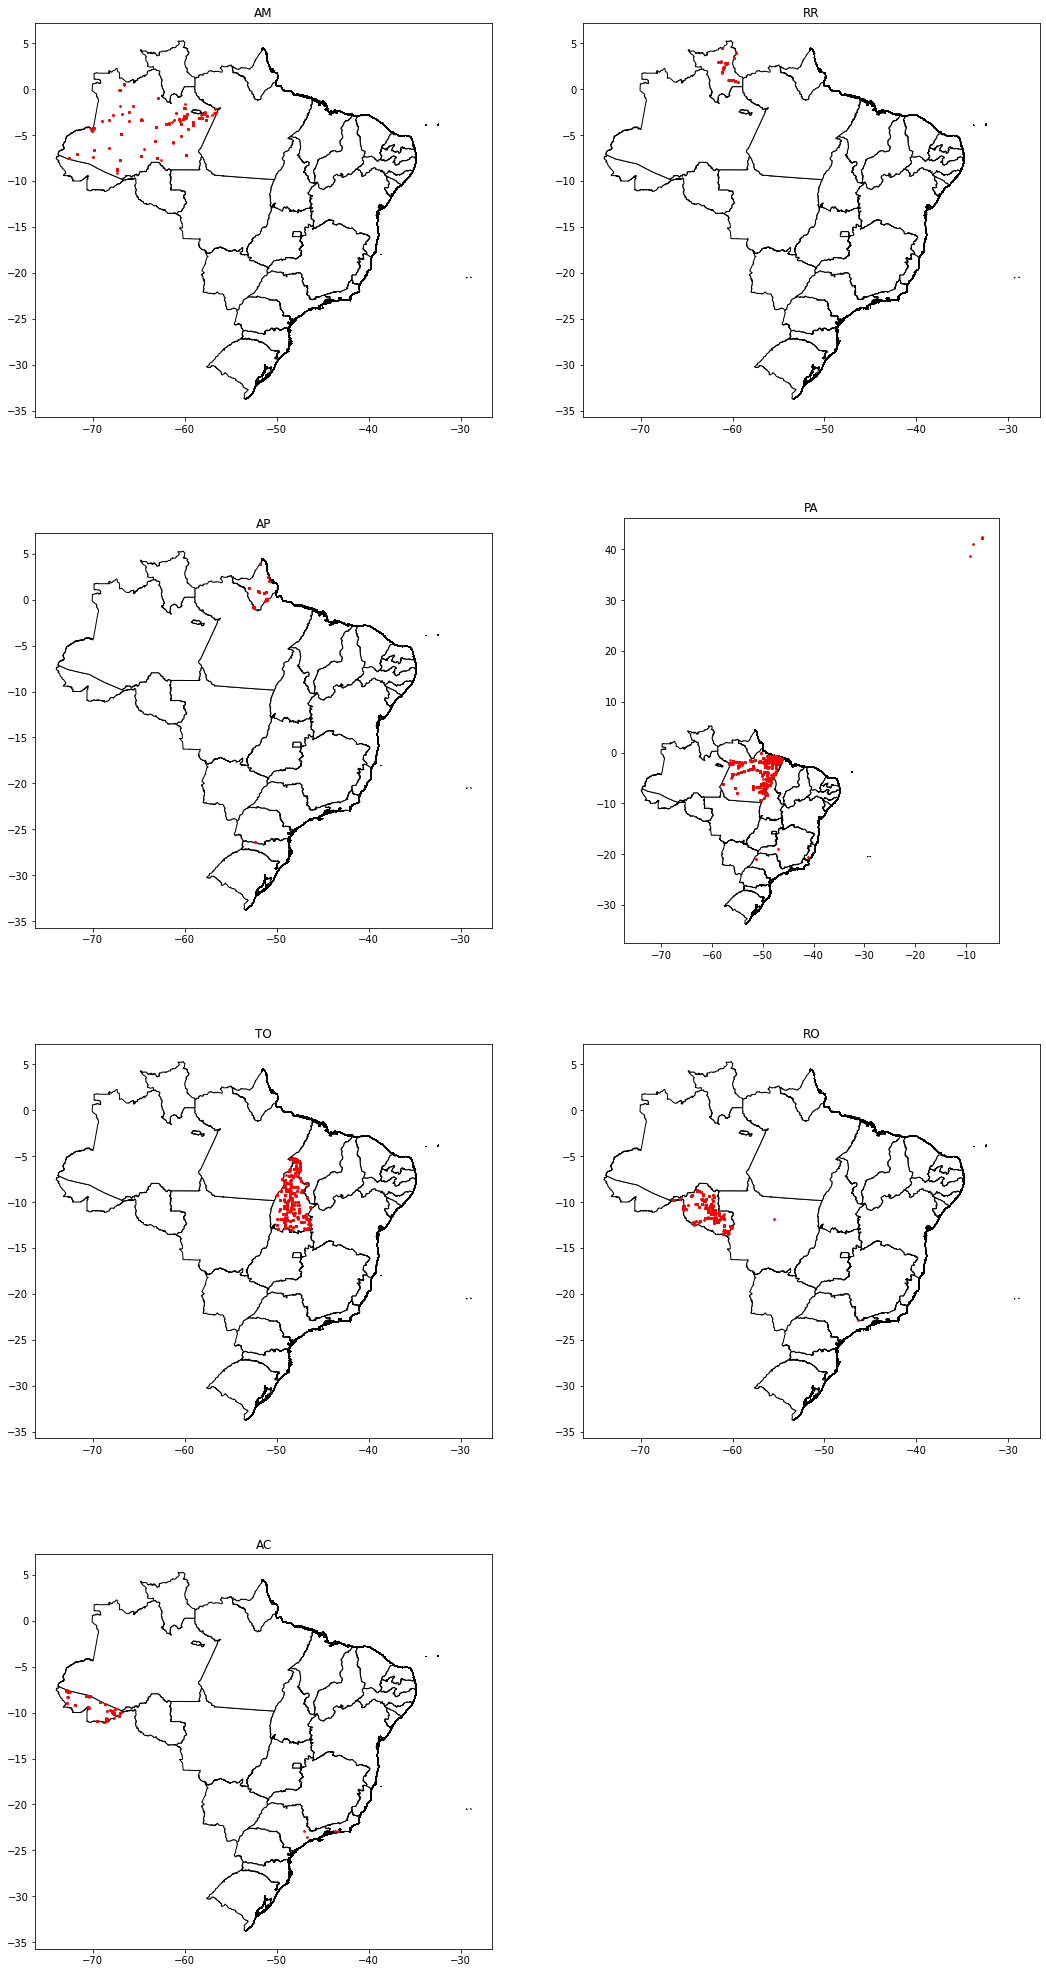

In [193]:
# Localização dos pedidos no norte
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(18, 36))
fig.delaxes(axes[3,1])
even_norte = norte + ['N/A']
state_grid = np.reshape(even_norte, (4, 2))
for state_row, ax_row in zip(state_grid, axes):
    for state, base_ax in zip(state_row, ax_row):
        if state == "N/A":
            continue
        base_ax.set_title(state)
        points_in_state = points[points['geolocation_state'] == state]
        states_ax = states_maps.plot(ax=base_ax, color='white', edgecolor='black')
        points_in_state.plot(ax=states_ax, color='red', markersize=3)

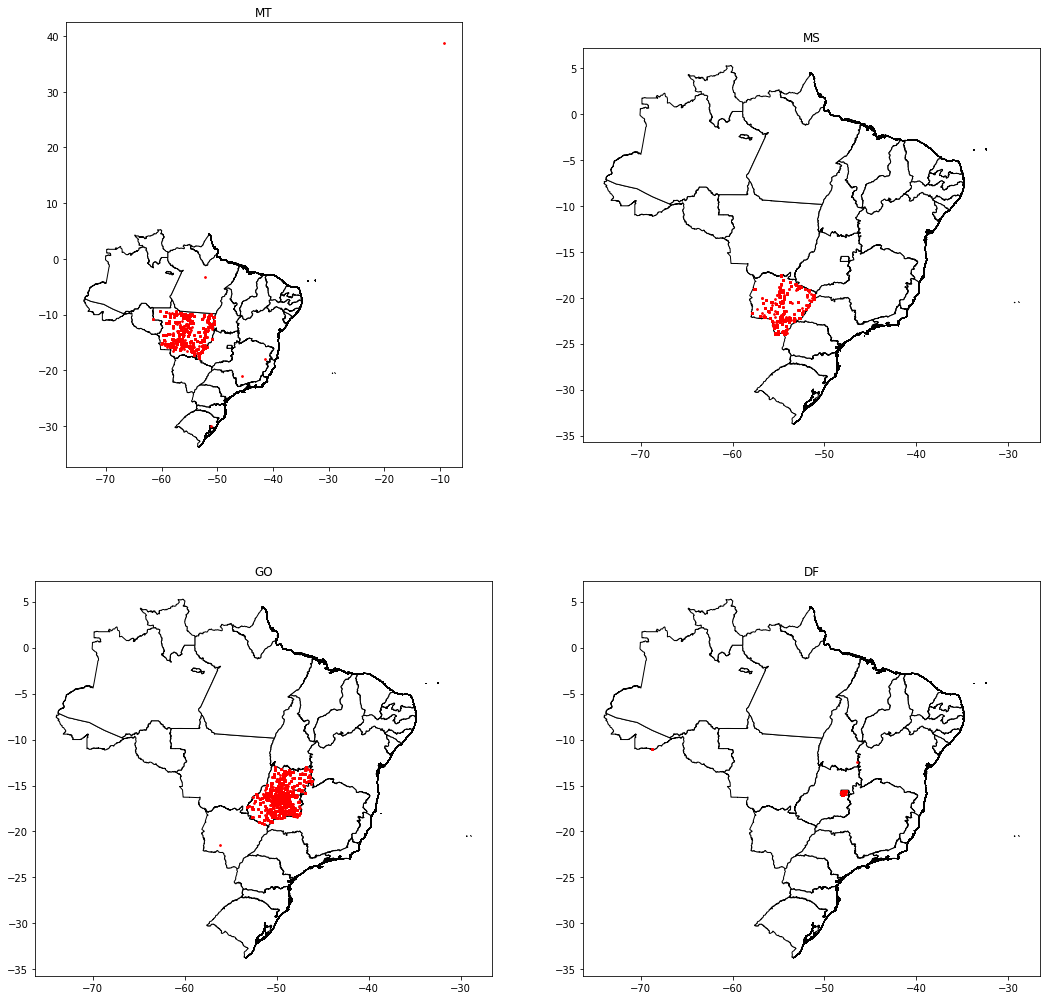

In [194]:
# Localização dos pedidos no centro_oeste
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 18))
state_grid = np.reshape(centro_oeste, (2, 2))
for state_row, ax_row in zip(state_grid, axes):
    for state, base_ax in zip(state_row, ax_row):
        base_ax.set_title(state)
        points_in_state = points[points['geolocation_state'] == state]
        states_ax = states_maps.plot(ax=base_ax, color='white', edgecolor='black')
        points_in_state.plot(ax=states_ax, color='red', markersize=3)

Observe que em alguns gráficos, alguns pontos encontram-se bem distantes da maior parte deles. Vamos concentrar esses pontos removendo outliers usando razão de duas variáveis.

Removeremos outliers do estado de Pernambuco utilizando razão de duas variáveis

In [195]:
points_pe = points[points['geolocation_state'] == 'PE'].copy()
print(len(points_pe))
points_pe['lat_per_lng'] = points_pe['geolocation_lat']/points_pe['geolocation_lng']

16432


In [196]:
points_pe['lat_per_lng'].describe()

count    16432.000000
mean         0.228886
std          0.011496
min          0.077670
25%          0.228732
50%          0.230473
75%          0.232489
max          0.505532
Name: lat_per_lng, dtype: float64

<AxesSubplot:>

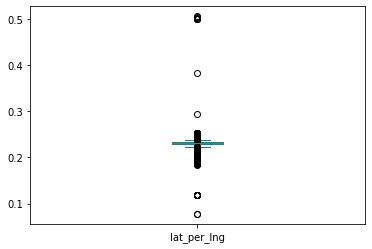

In [197]:
points_pe['lat_per_lng'].plot.box()

<AxesSubplot:>

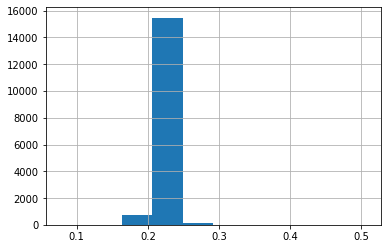

In [198]:
points_pe['lat_per_lng'].hist()

In [199]:
points_pe['lat_per_lng'] = np.log10(points_pe['lat_per_lng'])

<AxesSubplot:>

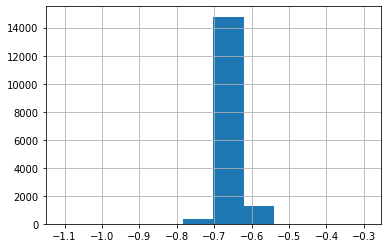

In [200]:
points_pe['lat_per_lng'].hist()

In [201]:
mad = abs(points_pe['lat_per_lng'] - points_pe['lat_per_lng'].median()).median()*(1/0.6745)

<AxesSubplot:>

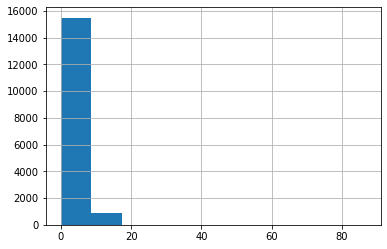

In [202]:
(abs(points_pe['lat_per_lng'] - points_pe['lat_per_lng'].median())/mad).hist()

In [203]:
points_pe[abs(points_pe['lat_per_lng'] - points_pe['lat_per_lng'].median())/mad > 3.5]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geometry,lat_per_lng
715892,53990,-3.845491,-32.413367,fernando de noronha,PE,POINT (-32.41337 -3.84549),-0.925772
715893,53990,-3.853092,-32.423525,fernando de noronha,PE,POINT (-32.42352 -3.85309),-0.925051
715896,53990,-3.846930,-32.415821,fernando de noronha,PE,POINT (-32.41582 -3.84693),-0.925643
715900,53990,-3.848319,-32.412384,fernando de noronha,PE,POINT (-32.41238 -3.84832),-0.925440
715908,53990,-3.853092,-32.423525,fernando de noronha,PE,POINT (-32.42352 -3.85309),-0.925051
...,...,...,...,...,...,...,...
724561,56903,-7.988312,-38.299790,serra talhada,PE,POINT (-38.29979 -7.98831),-0.680741
724562,56950,-7.863829,-38.756344,sao jose do belmonte,PE,POINT (-38.75634 -7.86383),-0.692709
724563,56903,-7.992830,-38.298048,serra talhada,PE,POINT (-38.29805 -7.99283),-0.680476
724564,56912,-7.982358,-38.283764,serra talhada,PE,POINT (-38.28376 -7.98236),-0.680883


In [204]:
inlier_points_pe = points_pe[abs(points_pe['lat_per_lng'] - points_pe['lat_per_lng'].median())/mad < 3.5]
print(len(inlier_points_pe))

13324


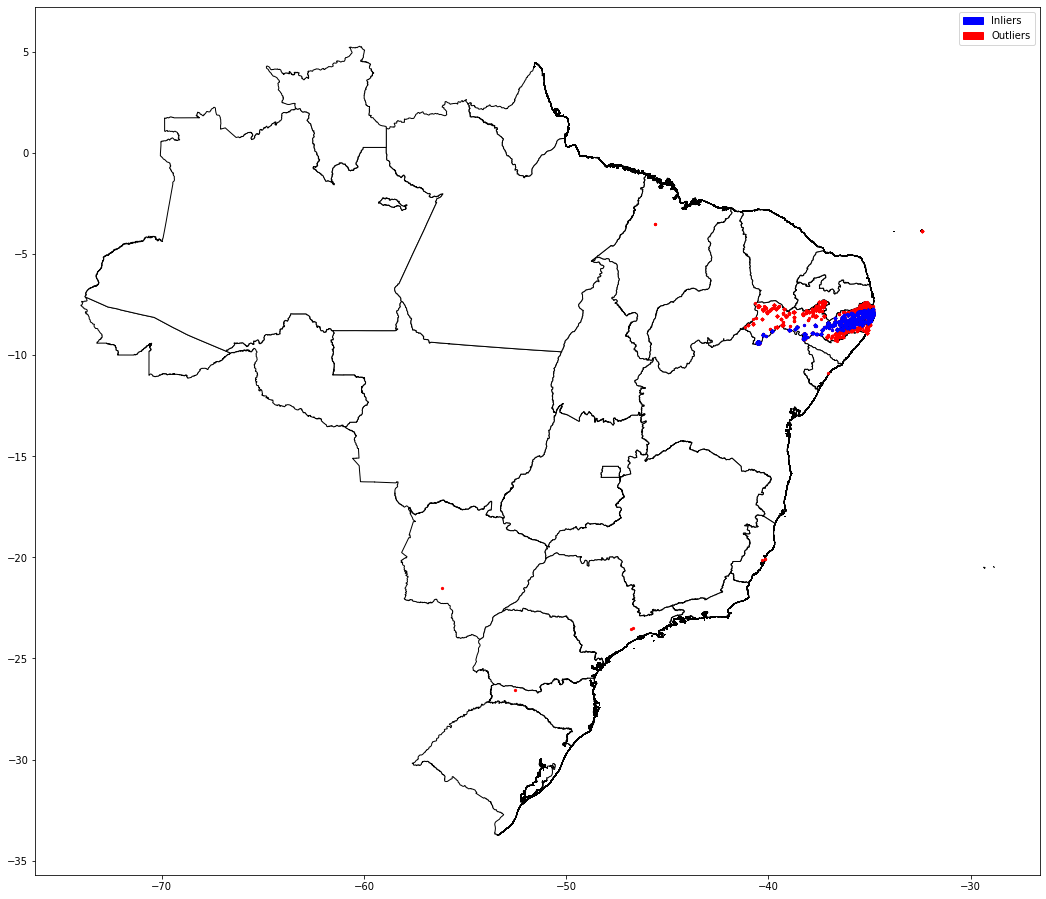

In [205]:
ax = states_maps.plot(color='white', edgecolor='black', figsize=(18,18))
outlier_points_pe = points_pe
outlier_points_pe.plot(ax=ax, color='red', markersize=5)
inlier_points_pe.plot(ax=ax, color='blue', markersize=5)
blue_patch = mpatches.Patch(color='blue', label='Inliers')
red_patch = mpatches.Patch(color='red', label='Outliers')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

# Estudo sobre os pedidos

In [206]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Como existem muitas categorias, é interessante buscar aquelas cuja distribuição de alguma variável segue uma normal. Escolheremos a variável peso. E a seguir, plotaremos os respectivos boxplots e histogramas, evidenciando e o que foi suposto nos testes.

In [207]:
# Categorias com mais de 100 registros

top_frequency_categories = products['product_category_name'].value_counts()[products['product_category_name'].value_counts() > 100].index.tolist()
tests = []

In [208]:
for i in range(0, len(top_frequency_categories)):
  statistic, p_value = stats.shapiro(products[products['product_category_name'] == top_frequency_categories[i]]['product_weight_g'])
  x = float(statistic) 
  shapiro_test = {
      "statistic": statistic,
      "p_value": p_value,
      "category": top_frequency_categories[i]
  }
  if(not math.isnan(x)):
    tests.append(shapiro_test)

In [209]:
tests = sorted(tests, key=lambda k: k['statistic'], reverse=True)

In [210]:
tests[:5]

[{'statistic': 0.9565004110336304,
  'p_value': 5.9364559490404645e-08,
  'category': 'moveis_escritorio'},
 {'statistic': 0.821455717086792,
  'p_value': 5.790418144968612e-11,
  'category': 'climatizacao'},
 {'statistic': 0.7942505478858948,
  'p_value': 1.5457492057169286e-13,
  'category': 'moveis_sala'},
 {'statistic': 0.7345268130302429,
  'p_value': 7.057234571034021e-13,
  'category': 'casa_conforto'},
 {'statistic': 0.7223107218742371,
  'p_value': 2.287406425302009e-19,
  'category': 'eletroportateis'}]

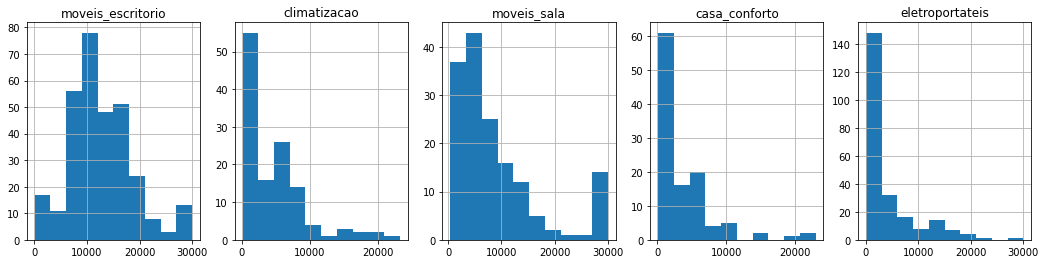

In [211]:
# Histogramas dos 5 principais testes
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18, 4))
for i in range(5):
  axes[i].hist(products[products['product_category_name'] == tests[:5][i]['category']]['product_weight_g'])
  axes[i].set_title(tests[:5][i]['category'])
  axes[i].grid(True)

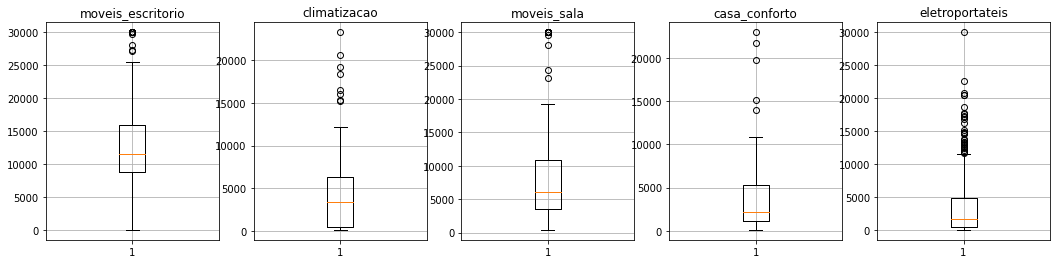

In [212]:
# Boxplot dos 5 principais testes
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18, 4))
for i in range(5):
  axes[i].boxplot(products[products['product_category_name'] == tests[:5][i]['category']]['product_weight_g'])
  axes[i].set_title(tests[:5][i]['category'])
  axes[i].grid(True)

Para cada uma das categorias descritas acima, vamos remover alguns outliers utilizando técnicas de remoção univariadas

# Removendo outlier utilizando z-score robusto

Para remover outliers, vamo escolher um subconjunto cuja distribuição dos dados esteja bastante esparsa. Por exemplo, escolheremos o 25º resultado dos testes obtidos na seção anterior.

In [213]:
from numpy import log10
pesos = products[products['product_category_name'] == tests[25]['category']]['product_weight_g']
print(len(pesos))

517


<AxesSubplot:>

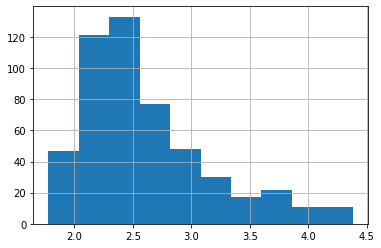

In [214]:
pesos_log = log10(pesos)
pesos_log.hist()

In [215]:
from numpy import abs
mad = abs(pesos_log - pesos_log.median()).median()*(1/0.6745)
print(mad)

0.3784618311390749


In [216]:
pesos_log.mad()

0.4375152664456083

<AxesSubplot:>

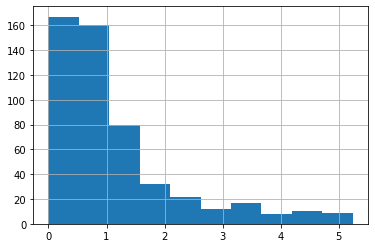

In [217]:
(abs(pesos_log - pesos_log.median())/mad).hist()

In [218]:
pesos_depois = pesos[abs(pesos_log - pesos_log.median())/mad < 3.5]
len(pesos_depois)

481

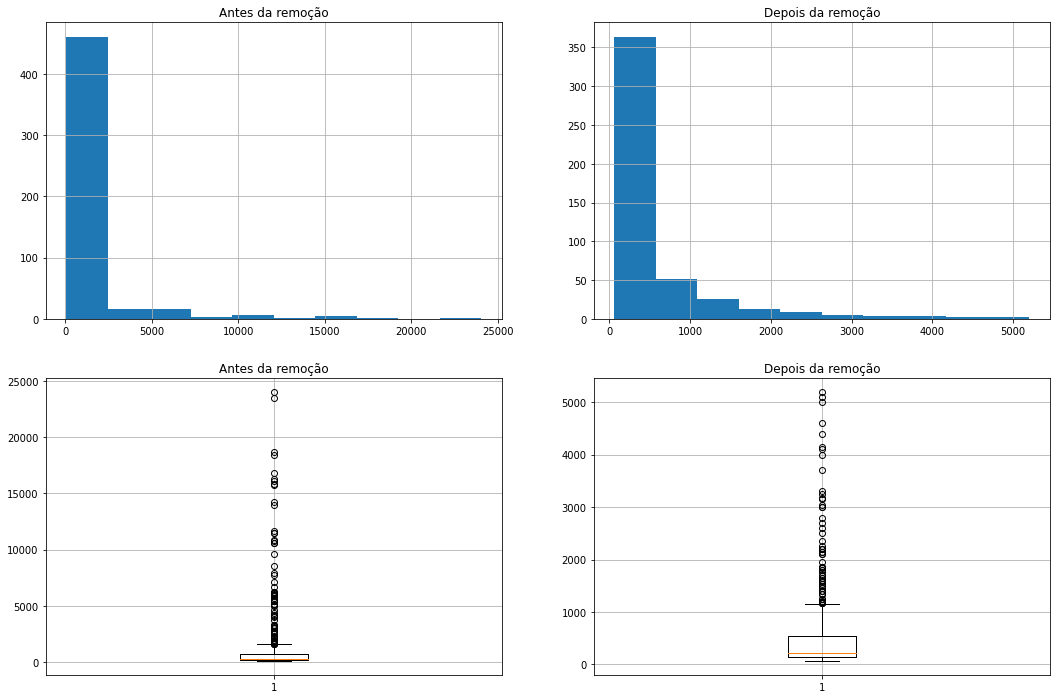

In [219]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 12))
axes[0][0].hist(pesos)
axes[0][0].set_title('Antes da remoção')
axes[0][0].grid(True)
axes[0][1].hist(pesos_depois)
axes[0][1].set_title('Depois da remoção')
axes[0][1].grid(True)
axes[1][0].boxplot(pesos)
axes[1][0].set_title('Antes da remoção')
axes[1][0].grid(True)
axes[1][1].boxplot(pesos_depois)
axes[1][1].set_title('Depois da remoção')
axes[1][1].grid(True)

# Removendo outliers utilizando método de tukey

Vamos escolher a mesma distribuição do caso anterior, a fim de comparar os resultados no final

In [220]:
pesos = products[products['product_category_name'] == tests[25]['category']]['product_weight_g']
print(len(pesos))

517


<AxesSubplot:>

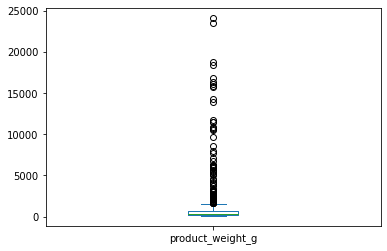

In [221]:
pesos.plot.box()

In [ ]:
pesos.hist()

<AxesSubplot:>

In [ ]:
pesos_log = log10(pesos)
pesos_log.hist()

In [ ]:
q1 = pesos_log.quantile(q=0.25)
q3 = pesos_log.quantile(q=0.75)
iqr = q3 - q1
print(iqr)

In [ ]:
pesos[pesos_log < (q1-1.5*iqr)]

In [ ]:
pesos[pesos_log > (q3+1.5*iqr)]

In [ ]:
pesos_depois = pesos[abs(pesos_log - pesos_log.median())/mad < 3.5]
len(pesos_depois)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 12))
axes[0][0].hist(pesos)
axes[0][0].set_title('Antes da remoção')
axes[0][0].grid(True)
axes[0][1].hist(pesos_depois)
axes[0][1].set_title('Depois da remoção')
axes[0][1].grid(True)
axes[1][0].boxplot(pesos)
axes[1][0].set_title('Antes da remoção')
axes[1][0].grid(True)
axes[1][1].boxplot(pesos_depois)
axes[1][1].set_title('Depois da remoção')
axes[1][1].grid(True)

Observe que para essa mesma distribuição de dados, o z-score robusto e o método de Tukey removem a mesma quantidade de dados.